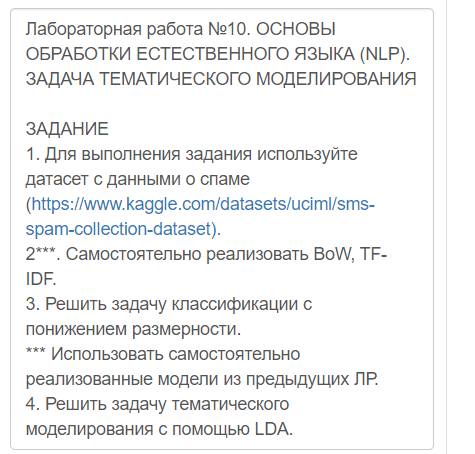

# 1 Загрузка и предобработка

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv(r"../data/spam.csv", encoding="latin-1", usecols=["v1", "v2"])
df.columns = ["type", "message"]
df

,type,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [3]:
df["type"].unique()

array(['ham', 'spam'], dtype=object)

In [4]:
df["type"] = df["type"].replace({"ham": 0, "spam": 1}).astype(bool)
df

,type,message
0,False,"Go until jurong point, crazy.. Available only ..."
1,False,Ok lar... Joking wif u oni...
2,True,Free entry in 2 a wkly comp to win FA Cup fina...
3,False,U dun say so early hor... U c already then say...
4,False,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,True,This is the 2nd time we have tried 2 contact u...
5568,False,Will Ì_ b going to esplanade fr home?
5569,False,"Pity, * was in mood for that. So...any other s..."
5570,False,The guy did some bitching but I acted like i'd...


In [5]:
import spacy

nlp = spacy.load("en_core_web_sm")


def lemmatize(string):
    return " ".join([word.lemma_ for word in nlp(string)])
    

df["message"] = df["message"].apply(lemmatize)

In [6]:
y = df["type"]
x = df["message"]

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf_vectorizer = TfidfVectorizer()
# tfidf = tfidf_vectorizer.fit_transform(x)
# tfidf_vectorizer.vocabulary_.__len__()

Так как в файле имеется 5572 сообщения, то присутствие слова в 2-3 сообщениях нам ничего не даст. Можем увеличить min_df (надеюсь)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=5)
tfidf = tfidf_vectorizer.fit_transform(x)
tfidf_vectorizer.vocabulary_.__len__()

4780

In [9]:
import numpy as np

x_np = np.asarray(tfidf.todense())
x_np.shape

(5572, 4780)

# 3 Классификация

In [10]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x_np, y, test_size=0.3)

In [12]:
from imblearn.over_sampling import RandomOverSampler

x_train, y_train = RandomOverSampler(sampling_strategy=1.0).fit_resample(x_train, y_train)

In [13]:
param_grid = {
    "estimator": [
            DecisionTreeClassifier(max_depth=5),
            GaussianNB(),
            LogisticRegression(),
        ],
    "max_features": np.arange(5, 21, 3)
}

bc = BaggingClassifier()
best_params = GridSearchCV(bc, param_grid).fit(x_train, y_train).best_params_
best_params

{'estimator': DecisionTreeClassifier(max_depth=5), 'max_features': 20}

In [14]:
bc = BaggingClassifier(**best_params)
bc.fit(x_train, y_train)
y_pred = bc.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.93      0.98      0.95      1456
        True       0.76      0.51      0.61       216

    accuracy                           0.92      1672
   macro avg       0.84      0.74      0.78      1672
weighted avg       0.91      0.92      0.91      1672



## Понижение размерности и ещё разок

Теперь попробую понизить размерность и применить ансамбль ещё раз, а также бахну нейронку

In [15]:
def test(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
    x_train, y_train = RandomOverSampler(sampling_strategy=1.0).fit_resample(x_train, y_train)

    bc = BaggingClassifier(**best_params)
    bc.fit(x_train, y_train)
    y_pred = bc.predict(x_test)
    print(classification_report(y_test, y_pred))

In [16]:
from sklearn.feature_selection import SelectKBest


skb = SelectKBest(k=30)
x_skb = skb.fit_transform(x_np, y)
x_skb.shape

(5572, 30)

In [17]:
test(x_skb, y)

              precision    recall  f1-score   support

       False       0.97      0.97      0.97      1425
        True       0.83      0.83      0.83       247

    accuracy                           0.95      1672
   macro avg       0.90      0.90      0.90      1672
weighted avg       0.95      0.95      0.95      1672



Ну тут прям хорошо, попробую другие методы понижения размерности. Например, PCA, которым я сам дэлал

In [18]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from typing import List, Tuple

class PCA_Hype():
    def __init__(self, k_components: int) -> None:
        self._k_components = k_components


    def fit_transform(self, x: pd.DataFrame) -> pd.DataFrame:
        scaled_x = np.array(self._scale(x))
        cov_matrix = self._get_cov_matrix(x, x.shape[1])
        k_eigen_pairs = self._get_first_k_eigen_pairs(cov_matrix)
        matrix_from_eigen_vectors = self._get_matrix_from_eigen_pairs(k_eigen_pairs)
        return pd.DataFrame(scaled_x.dot(matrix_from_eigen_vectors))


    def _get_cov_matrix(self, x: pd.DataFrame, size: int) -> np.ndarray:
        matrix = [
            [ round(self._get_cov(x.iloc[:, i], x.iloc[:, j]), 4) for j in range(size) ] for i in range(size)
        ]
        return np.array(matrix)


    def _scale(self, x: pd.DataFrame) -> np.ndarray:
        return StandardScaler().fit_transform(x)


    def _get_cov(self, v1, v2) -> float:
        v1, v2 = np.array(v1), np.array(v2)

        av_1, av_2 = np.average(v1), np.average(v2)

        v1 -= av_1
        v2 -= av_2

        return float(np.average(v1 * v2))
    

    def _get_first_k_eigen_pairs(self, matrix: np.ndarray) -> List[Tuple]:
        eigen = np.linalg.eig(matrix)

        eigen_values = eigen[0]
        eigen_vectors = eigen[1]

        eigen_pairs = [(eigen_values[i], eigen_vectors[i]) for i in range(eigen_values.__len__())]
        return sorted(eigen_pairs, key=lambda pair: pair[0], reverse=True)[:self._k_components]
       
        
    def _get_matrix_from_eigen_pairs(self, pairs: List[Tuple]) -> np.ndarray:
        vectors = [pair[1] for pair in pairs]
        return np.stack(vectors, axis=1)

Понизим размерность датасета после SelectKBest

In [19]:
import pandas as pd

x_pca_hype = PCA_Hype(k_components=5).fit_transform(pd.DataFrame(x_skb))

x_train, x_test, y_train, y_test = train_test_split(x_pca_hype, y, test_size=0.3)
x_train, y_train = RandomOverSampler(sampling_strategy=1.0).fit_resample(x_train, y_train)

bc = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5))
bc.fit(x_train, y_train)
y_pred = bc.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.94      0.96      1448
        True       0.69      0.91      0.78       224

    accuracy                           0.93      1672
   macro avg       0.84      0.92      0.87      1672
weighted avg       0.95      0.93      0.94      1672



Снизили размерность ещё в 6 раз, нормально. Точность в пределах погрешности.

Теперь RFE.

In [20]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=DecisionTreeClassifier(max_depth=5), n_features_to_select=30, step=300)
x_rfe = rfe.fit_transform(x_np, y)
test(x_rfe, y)

              precision    recall  f1-score   support

       False       0.96      0.98      0.97      1426
        True       0.88      0.76      0.81       246

    accuracy                           0.95      1672
   macro avg       0.92      0.87      0.89      1672
weighted avg       0.95      0.95      0.95      1672



Возьму результат работы своего алгоритма.

In [21]:
from tensorflow import keras

classmodel = keras.Sequential([
    keras.layers.Input([5, ]),

    keras.layers.Dense(64, activation="tanh"),

    keras.layers.Dense(128, activation="sigmoid"),
    keras.layers.Dropout(0.1),

    keras.layers.Dense(128, activation="sigmoid"),
    keras.layers.Dropout(0.1),

    keras.layers.Dense(64, activation="tanh"),

    keras.layers.Dense(2, activation="softmax")
])

In [22]:
classmodel.compile(optimizer=keras.optimizers.Adam(learning_rate=0.006), loss='sparse_categorical_crossentropy')

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x_pca_hype, y, test_size=0.3)

In [24]:
classmodel.fit(x_train, y_train, epochs=200)

Epoch 1/200
122/122 [==============================] - 2s 3ms/step - loss: 0.2729
Epoch 2/200
122/122 [==============================] - 0s 3ms/step - loss: 0.2110
Epoch 3/200
122/122 [==============================] - 0s 3ms/step - loss: 0.2034
Epoch 4/200
122/122 [==============================] - 0s 3ms/step - loss: 0.1897
Epoch 5/200
122/122 [==============================] - 0s 3ms/step - loss: 0.1690
Epoch 6/200
122/122 [==============================] - 0s 3ms/step - loss: 0.1576
Epoch 7/200
122/122 [==============================] - 0s 3ms/step - loss: 0.1565
Epoch 8/200
122/122 [==============================] - 0s 3ms/step - loss: 0.1483
Epoch 9/200
122/122 [==============================] - 0s 3ms/step - loss: 0.1419
Epoch 10/200
122/122 [==============================] - 0s 3ms/step - loss: 0.1392
Epoch 11/200
122/122 [==============================] - 0s 3ms/step - loss: 0.1364
Epoch 12/200
122/122 [==============================] - 0s 3ms/step - loss: 0.1314
Epoch 13/200


In [25]:
y_pred = classmodel.predict(x_test)
y_pred = [np.argmax(pred) for pred in y_pred]

print(classification_report(y_test, y_pred))

53/53 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

       False       0.97      1.00      0.98      1445
        True       0.96      0.78      0.86       227

    accuracy                           0.97      1672
   macro avg       0.96      0.89      0.92      1672
weighted avg       0.97      0.97      0.96      1672



Нейронка справилась с этой задачей заметно лучше, при этом обучение было сравнительно быстрым

# Тематическое моделирование LDA

In [26]:
from sklearn.decomposition import LatentDirichletAllocation

Данные можно условно поделить на 2 темы - спам и его отсутствие

In [27]:
lda = LatentDirichletAllocation(n_components=2,
                                learning_method='online',  # использует для обучения небольшой батч и работает быстрее
).fit(tfidf)

In [28]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [29]:
feature_names = tfidf_vectorizer.get_feature_names_out()
feature_names

array(['00', '00 sub', '00 sub 16', ..., 'ze', 'ìï', 'ûò'], dtype=object)

In [30]:
lda.components_

array([[ 2.13098118,  1.13094009,  1.13094003, ...,  1.83562734,
         0.5409299 ,  0.82186629],
       [ 0.51823971,  0.50147494,  0.501475  , ...,  0.50503862,
        18.22683475,  2.53949885]])

In [31]:
for topic_idx, topic in enumerate(lda.components_):
    print("Topic #%d:" % topic_idx)
    words = [str(feature_names[i]) for i in np.array(topic).argsort()[:-20:-1]]
    print(" ".join(words))

Topic #0:
call your to you send free be you be now text from or for txt new pls message the stop
Topic #1:
be you to not do the in it my have and go get that ok will can of so


Ура!